In [1]:
# FASTA: Full Average Scaled Tiling Attention
# implement a sparse attention using triton using the following methods
# in the standard self attention, the attention weight is computed like this: attn_weight = query @ key.transpose(-2, -1) * scale_factor
# assume a function:
# def att_weight(Q,K_T):
#    return Q@K_T
# FASTA is a sparse approximation for the above function which works as follows:
# def att_weight(Q,K_T,n_chunks):
#    return Q@K_T # sparse approximation
# the Q and K are divided into equal sized chunks
# assume  QxK^T to be [Q0,Q1,....Qn-1]*[K0,K1,....Kn-1] where each of them are equal sized chunks from the initial embeddings.
# in the full product if Q0*K0 then you do the regular multiplication, but if Q0*K1 or whenever the indices are not same, do avg(Q0)*avg(K1) and then broadcast this value in the shape of that grid.
# create a triton kernel which implements the above operation if i==j then intra-index, if i!=j then inter-index
# generate code and test case for the kernels first before proceeding to the full implementation
# the overall time complexity should be O(n^2/c^2+n*d*c) where c is number of chunks

In [2]:
################################################################################

In [3]:
import torch
import triton
import triton.language as tl
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # For progress bar

@triton.jit
def fasta_kernel(
    Q_ptr, K_ptr, attn_ptr,
    N, D: tl.constexpr, BLOCK_SIZE: tl.constexpr,
    stride_q0, stride_q1,
    stride_k0, stride_k1,
    stride_attn0, stride_attn1,
):
    # Get the program ID and compute row and column block indices
    pid = tl.program_id(0)
    n_blocks = tl.cdiv(N, BLOCK_SIZE)
    row_block_idx = pid // n_blocks
    col_block_idx = pid % n_blocks
    
    # Calculate the starting positions of the current block
    row_start = row_block_idx * BLOCK_SIZE
    col_start = col_block_idx * BLOCK_SIZE
    
    # Create block offsets for Q and K
    offs_q = row_start + tl.arange(0, BLOCK_SIZE)
    offs_k = col_start + tl.arange(0, BLOCK_SIZE)
    offs_d = tl.arange(0, D)
    
    # Initialize the accumulator for attention weights
    acc = tl.zeros((BLOCK_SIZE, BLOCK_SIZE), dtype=tl.float32)
    
    # Compute memory addresses for Q and K blocks
    q_ptrs = Q_ptr + offs_q[:, None] * stride_q0 + offs_d[None, :] * stride_q1
    k_ptrs = K_ptr + offs_k[:, None] * stride_k0 + offs_d[None, :] * stride_k1
    
    # Create masks to handle boundary conditions
    q_mask = offs_q[:, None] < N
    k_mask = offs_k[:, None] < N
    
    # Load Q and K blocks with masking
    q_block = tl.load(q_ptrs, mask=q_mask, other=0.0)  # Shape: (BLOCK_SIZE, D)
    k_block = tl.load(k_ptrs, mask=k_mask, other=0.0)  # Shape: (BLOCK_SIZE, D)
    
    # Intra-block attention: exact computation using block-wise matmul
    if tl.abs(row_block_idx - col_block_idx)<2:
        # Perform block-wise matmul: Q_block @ K_block.T
        # Q_block: (BLOCK_SIZE, D)
        # K_block: (BLOCK_SIZE, D) -> Transposed to (D, BLOCK_SIZE)
        # Result: (BLOCK_SIZE, BLOCK_SIZE)
        acc += tl.dot(q_block, tl.trans(k_block))  # (BLOCK_SIZE, D) @ (D, BLOCK_SIZE) = (BLOCK_SIZE, BLOCK_SIZE)
    
    # # Inter-block attention:
    else:
        # Compute vector averages for Q and K
        # q_vector = tl.sum(q_block, axis=1)  # Shape: (BLOCK_SIZE,)
        # k_vector = tl.sum(k_block, axis=1) # Shape: (BLOCK_SIZE,)
        
        # # Compute the outer product of the averaged vectors
        # outer = q_vector[:, None] * k_vector[None, :]
        # acc += outer/(D**2)

        q_vector = tl.sum(q_block, axis=1) / D  # Manually calculate the mean
        k_vector = tl.sum(k_block, axis=1) / D  # Manually calculate the mean
        
        # Outer product using mean vectors
        outer = q_vector[:, None] * k_vector[None, :]
        acc += outer / D

    
    # Calculate offsets for storing the attention weights
    offs_attn_i = row_start + tl.arange(0, BLOCK_SIZE)
    offs_attn_j = col_start + tl.arange(0, BLOCK_SIZE)
    
    # Compute memory addresses for storing the attention weights
    attn_ptrs = attn_ptr + offs_attn_i[:, None] * stride_attn0 + offs_attn_j[None, :] * stride_attn1
    
    # Create a mask to handle boundary conditions during storage
    mask = (offs_attn_i[:, None] < N) & (offs_attn_j[None, :] < N)
    
    # Store the computed attention weights with masking
    tl.store(attn_ptrs, acc, mask=mask)

def fasta_attn(Q, K, block_size):
    """
    Computes FASTA attention using Triton with optimized intra-block matmul and Gaussian-like spread.
    
    Args:
        Q (torch.Tensor): Query tensor of shape (N, D)
        K (torch.Tensor): Key tensor of shape (N, D)
        block_size (int): Size of attention blocks
    
    Returns:
        torch.Tensor: Attention weights of shape (N, N)
    """
    N, D = Q.shape
    # Ensure tensors are contiguous
    Q = Q.contiguous()
    K = K.contiguous()
    
    # Create output tensor
    attn = torch.empty((N, N), device=Q.device, dtype=Q.dtype)
    
    # Calculate grid size
    n_blocks = triton.cdiv(N, block_size)
    grid = (n_blocks * n_blocks,)
    
    # Launch kernel
    fasta_kernel[grid](
        Q, K, attn,
        N, D, block_size,
        Q.stride(0), Q.stride(1),
        K.stride(0), K.stride(1),
        attn.stride(0), attn.stride(1),
    )
    
    return attn

Warming up the GPU...
Starting benchmarking...
Benchmarking standard self-attention...


Standard Self-Attention: 100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 170.45it/s]


Benchmarking optimized FASTA attention...


Optimized FASTA Attention: 100%|████████████████████████████████████| 1000/1000 [00:05<00:00, 183.73it/s]


Benchmarking completed!


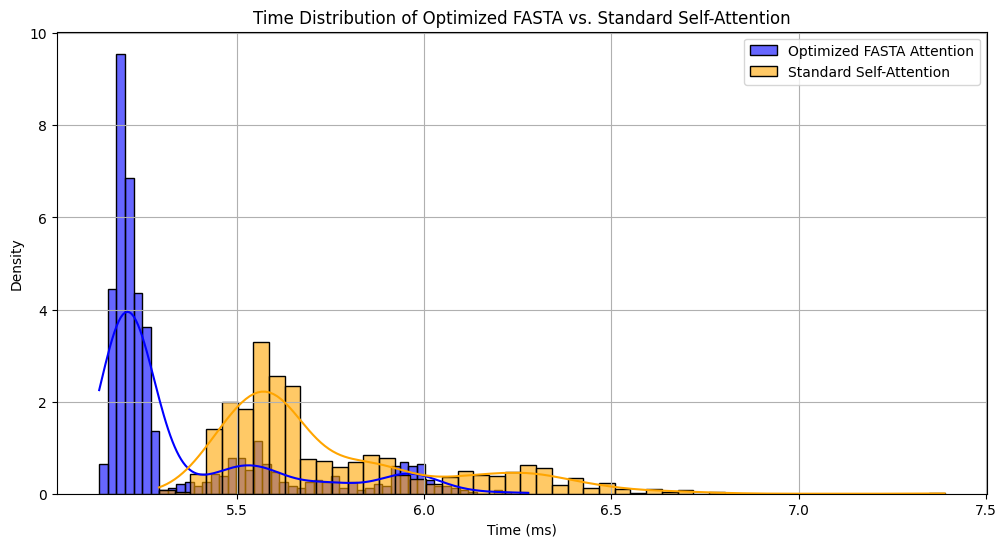

Summary Statistics:
Optimized FASTA Attention - Mean: 5.3519 ms, Std: 0.2545 ms
Standard Self-Attention - Mean: 5.7530 ms, Std: 0.3035 ms
Percentage improvement: 7.0%


In [4]:
def test_fasta_attention_benchmark():
    """
    Benchmark function for optimized FASTA attention implementation
    and standard self-attention. Runs each attention computation 100 times and
    plots the time distributions.
    """
    # Test parameters
    N = 16384  # Sequence length (e.g., 16384)
    D = 64        # Hidden dimension
    block_size = int(math.sqrt(N))
    device = 'cuda'
    
    # Ensure CUDA is available
    assert torch.cuda.is_available(), "CUDA is not available. Please run on a CUDA-enabled device."
    
    # Generate random inputs
    torch.manual_seed(0)
    Q = torch.randn(N, D, device=device, dtype=torch.float32)
    K = torch.randn(N, D, device=device, dtype=torch.float32)
    
    # Warm-up runs to stabilize GPU performance
    print("Warming up the GPU...")
    for _ in range(10):
        attn_ref = Q @ K.T
        attn_fasta = fasta_attn(Q, K, block_size=block_size)
    torch.cuda.synchronize()
    
    # Number of benchmarking iterations
    num_iterations = 1000
    
    # Initialize lists to store timing data
    standard_times = []
    fasta_times = []
    
    print("Starting benchmarking...")
    
    # Benchmark standard self-attention
    print("Benchmarking standard self-attention...")
    for _ in tqdm(range(num_iterations), desc="Standard Self-Attention"):
        # Create CUDA events for timing
        start_std = torch.cuda.Event(enable_timing=True)
        end_std = torch.cuda.Event(enable_timing=True)
        
        # Record start event
        start_std.record()
        
        # Compute standard self-attention
        attn_ref = Q @ K.T
        
        # Record end event
        end_std.record()
        
        # Wait for all CUDA operations to finish
        torch.cuda.synchronize()
        
        # Calculate elapsed time in milliseconds
        elapsed_std = start_std.elapsed_time(end_std)
        
        # Append to list
        standard_times.append(elapsed_std)
    
    # Benchmark optimized FASTA attention
    print("Benchmarking optimized FASTA attention...")
    for _ in tqdm(range(num_iterations), desc="Optimized FASTA Attention"):
        # Create CUDA events for timing
        start_fasta = torch.cuda.Event(enable_timing=True)
        end_fasta = torch.cuda.Event(enable_timing=True)
        
        # Record start event
        start_fasta.record()
        
        # Compute optimized FASTA attention
        attn_fasta = fasta_attn(Q, K, block_size=block_size)
        
        # Record end event
        end_fasta.record()
        
        # Wait for all CUDA operations to finish
        torch.cuda.synchronize()
        
        # Calculate elapsed time in milliseconds
        elapsed_fasta = start_fasta.elapsed_time(end_fasta)
        
        # Append to list
        fasta_times.append(elapsed_fasta)
    
    print("Benchmarking completed!")
    
    # Convert timing lists to NumPy arrays for easier handling
    fasta_times = torch.tensor(fasta_times).cpu().numpy()
    standard_times = torch.tensor(standard_times).cpu().numpy()
    
    # Plotting the time distributions
    plt.figure(figsize=(12, 6))
    
    sns.histplot(fasta_times, color='blue', label='Optimized FASTA Attention', kde=True, stat="density", bins=50, alpha=0.6)
    sns.histplot(standard_times, color='orange', label='Standard Self-Attention', kde=True, stat="density", bins=50, alpha=0.6)
    
    plt.title('Time Distribution of Optimized FASTA vs. Standard Self-Attention')
    plt.xlabel('Time (ms)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print summary statistics
    print("Summary Statistics:")
    print(f"Optimized FASTA Attention - Mean: {fasta_times.mean():.4f} ms, Std: {fasta_times.std():.4f} ms")
    print(f"Standard Self-Attention - Mean: {standard_times.mean():.4f} ms, Std: {standard_times.std():.4f} ms")
    print(f"Percentage improvement: {100*(1 - fasta_times.mean()/standard_times.mean()):.1f}%")
    
    # Optional: Save the plot
    # plt.savefig('attention_benchmark_optimized.png')

if __name__ == "__main__":
    test_fasta_attention_benchmark()